# P2P CDN test in a controlled enviroment

The tests were run with up to 30 client sessions on 15 computers

Therefore events were created and all data was transmittioned over the network as it would for a normal event.
All clients used a recent Chrome browser to ensure that they are capable of running the cdn.

The resolution of the stream was limited to 360p. Higher resolutions still have some problems with the cdn most certanly timing issues. With resolutions higher than 360p it happends quite often that the clients request a hls segement but no one has loaded it so far. This happends because of the higher downloading times of the segements.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx



In [137]:
p_2 = pd.read_json("2.json")
p_6 = pd.read_json("6.json")
p_10 = pd.read_json("10.json")
p_15 = pd.read_json("15.json")
p_30 = pd.read_json("30.json")

    Total  Peer  Server  Min #Server Requests
2     203    99     104            101.500000
6     704   574     130            117.333333
10   1066   738     328            106.600000
15   1541  1035     506            102.733333
30   2927  2125     802             97.566667


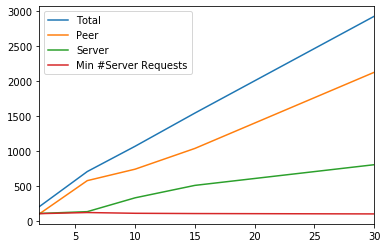

In [162]:
datasets = [p_2, p_6, p_10, p_15, p_30]
labels = ['2 Clients', '6 Clients', '10 Clients', '15 Clients', '30 Clients']
result = []
index = [2, 6, 10, 15, 30]

for i, dataset in enumerate(datasets):
    grouped = dataset.groupby('method').size()
    total = grouped[0] + grouped[1]
    peer = grouped[0]
    server = grouped[1]
    minimum = total/index[i]
    result.append([total, peer, server, minimum])
test = pd.DataFrame(result, index=index, columns=['Total', 'Peer', 'Server', 'Min #Server Requests']) 
print(test)
test.plot()

# Pie Charts by Delivery type

3
7
54
76
152


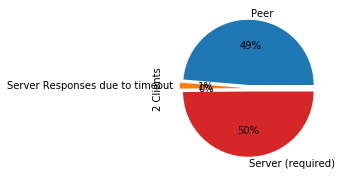

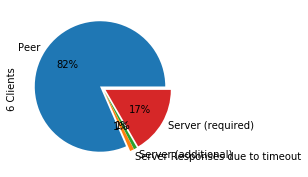

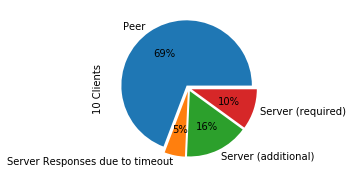

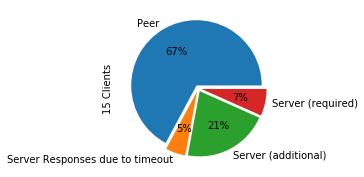

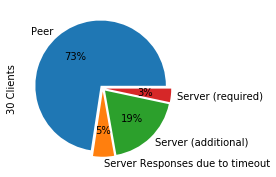

In [166]:
for i, data in enumerate(result):
    minimal = data[-1]
    dataset = datasets[i]
    serverResponses = dataset.loc[dataset['method'] == 'serverResponse']
    mask = serverResponses['loadTime'] > 3000
    timeOuts = serverResponses[mask]['loadTime'].count()
    print(timeOuts)
    df = pd.DataFrame({labels[i]: [data[1], timeOuts, max(data[2]-minimal-timeOuts, 0), minimal]}, index=['Peer', 'Server Responses due to timeout', 'Server (additional)', 'Server (required)'])
    plot = df.plot.pie(y=labels[i], figsize=(3, 3), autopct='%1.0f%%', explode=[0.05, 0.05, 0.05, 0.05]).get_legend().remove()
    
    # als stacked bars
    # reicht für schule mesh per klasxse
    
    # schulseite usecase nachstellen
    
    # in BESTEHENDEN client einbauen
    # 
    # dashboard
    # kurs 
    # thema
    # eine sache mit datenlast GROßE DATEI
    
1 mal nur dashboar oder 1 mal 3 clicks
wie gleichzeitig dürfen die schüler ihre geräte anmachen

1 mal nur Anwendung
1 mal anwendung plus content
1 mal nur content (nachladen)

massen test gegen staging (Slidesync)

https://observablehq.com/@d3/chord-dependency-diagram
    https://www.google.com/search?q=stacked+bar&oq=stacked+bar&aqs=chrome..69i57j0l5.4392j1j7&sourceid=chrome&ie=UTF-8

# cpu memory mitschreiben um zu gucken das das kein bottleneck ist
# server amazon 1 dicke maschiene
# Eigener account

# alles pupetter

# Analysis of loading times

## Average loading times based on all loaded hls segements:

All values are in ms.

peerResponses with loading times > 3000ms time out and are handled as serverResponse

In [7]:
data = pd.concat(datasets)
print(data.groupby('method').describe())

               loadTime                                                       \
                  count        mean          std    min        25%       50%   
method                                                                         
peerResponse     4571.0  201.607578   190.145881  27.02  110.02500  160.6500   
serverResponse   1870.0  531.334527  1089.173405   9.41   34.12625   61.5525   

                                   
                     75%      max  
method                             
peerResponse    229.9625  2832.27  
serverResponse   97.3625  5177.69  


## Server loading time compared with Peer loading times without outimed request

After a Peer Request is timed out, the request is loaded from the server. These requests have a loading time bigger that 3000ms. Those are not representative for the server loading times so we dont want to take those into account while comparing loading times.

count    1577.000000
mean       63.613849
std        62.995708
min         9.410000
25%        32.380000
50%        49.090000
75%        77.470000
max       649.005000
Name: loadTime, dtype: float64


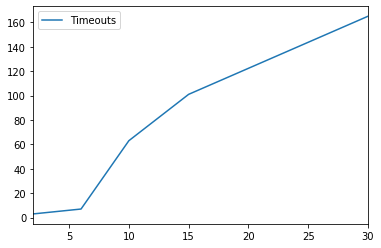

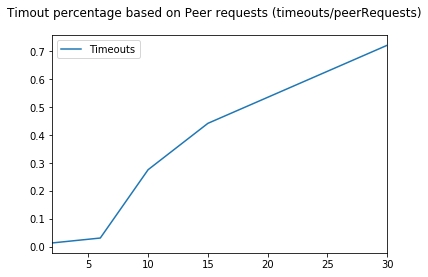

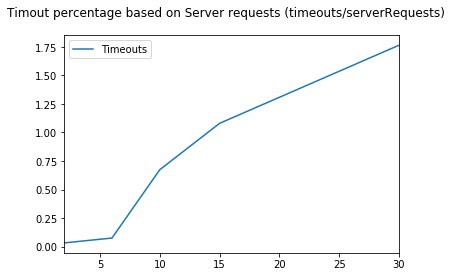

In [156]:
allPeerData = pd.concat(datasets).loc[data['method'] == 'peerResponse']
allServerData = pd.concat(datasets).loc[data['method'] == 'serverResponse']

data = pd.concat(datasets)
serverResponses = data.loc[data['method'] == 'serverResponse']
mask = serverResponses['loadTime'] < 1000
print(serverResponses[mask]['loadTime'].describe())

result = []
for i, dataset in enumerate(datasets):
    # grouped = dataset.groupby('method').size()
    #dataset = dataset.loc[data['method'] == 'serverResponse']
    mask = dataset['loadTime'] > 1000
    timeouts = [dataset[mask]['loadTime'].size]
    result.append(timeouts)
test = pd.DataFrame(result, index=index, columns=['Timeouts']) 
plot = test.plot()
plt.savefig("timeouts.pdf")

result = []
for i, dataset in enumerate(datasets):
    # grouped = dataset.groupby('method').size()
    #dataset = dataset.loc[data['method'] == 'serverResponse']
    mask = dataset['loadTime'] > 1000
    timeouts = (dataset[mask]['loadTime'].size/allPeerData.size)*100# [dataset[mask]['loadTime'].size]
    result.append(timeouts)
test = pd.DataFrame(result, index=index, columns=['Timeouts']) 
plot = test.plot()
plt.suptitle("Timout percentage based on Peer requests (timeouts/peerRequests)")

plt.savefig("timeouts_peer.pdf")

result = []
for i, dataset in enumerate(datasets):
    # grouped = dataset.groupby('method').size()
    #dataset = dataset.loc[data['method'] == 'serverResponse']
    mask = dataset['loadTime'] > 1000
    timeouts = (dataset[mask]['loadTime'].size/allServerData.size)*100# [dataset[mask]['loadTime'].size]
    result.append(timeouts)
test = pd.DataFrame(result, index=index, columns=['Timeouts']) 
plot = test.plot()
plt.suptitle("Timout percentage based on Server requests (timeouts/serverRequests)")

plt.savefig("timeouts_server.pdf")


# Network graphs

In [169]:
for i, dataset in enumerate(datasets):
    # ------- DIRECTED#
    peerIds = dataset.get('from').append(dataset.get('peerId'))
    #peerIds.drop(peerIds.index['server'])
    peerIds = peerIds.unique()
    peerIds = np.delete(peerIds, np.where(peerIds == 'server'))
    labels = [*range(1,peerIds.size+1)]
    fromIds = dataset.get('peerId').replace(peerIds, labels) # data.get('peerId')
    toIds = dataset.get('from').replace(peerIds, labels)

    # Build a dataframe with your connections
    # This time a pair can appear 2 times, in one side or in the other!
    df = pd.DataFrame({ 'from': fromIds, 'to': toIds})
    # Build your graph. Note that we use the DiGraph function to create the graph!
    G=nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph() )

    #pos=nx.circular_layout(G) 
    # Make the graph
    #nx.draw(G, pos=pos, with_labels=True, node_size=1500, alpha=1, arrows=True)
    #plt.savefig(str(i)+".pdf")
    #plt.savefig(str(i)+".png")

    #plt.clf()
    #G.clear()
# gewichtung chord
# ANZAHL REQUEST


![test](0.png)
![test](1.png)
![test](2.png)
![test](3.png)
![test](4.png)